In [5]:
import yfinance as yf

In [6]:
msft = yf.Ticker("MSFT")
msft_hist = msft.history(period="max")

In [7]:
import os
import pandas as Pd

DATA_PATH = "msft_data.json"

if os.path.exists(DATA_PATH):
    #read from file if weve already downloaded the data
    with open(DATA_PATH) as f:
        msft_hit = pd.read_json(DATA_PATH)
else:
    msft = yf.Ticker("MSFT")
    msft_hist = msft.history(period="max")
    
    #save file to json in case we need it later. prevents having to redownload
    msft_hist.to_json(DATA_PATH)

In [8]:
msft_hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,0.055654,0.063838,0.055654,0.061109,1031788800,0.0,0.0
1986-03-14,0.061109,0.064384,0.061109,0.063292,308160000,0.0,0.0
1986-03-17,0.063292,0.064929,0.063292,0.064384,133171200,0.0,0.0
1986-03-18,0.064384,0.064929,0.062201,0.062746,67766400,0.0,0.0
1986-03-19,0.062746,0.063292,0.061109,0.061655,47894400,0.0,0.0


<AxesSubplot:xlabel='Date'>

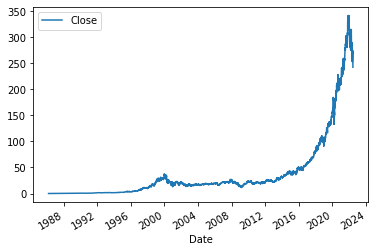

In [9]:
# Visualize microsoft stock prices
msft_hist.plot.line(y="Close", use_index=True)

In [10]:
# Ensure we know the actual closing price
data = msft_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = msft_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]

In [11]:
data.head()

,Actual_Close,Target
Date,,
1986-03-13,0.061109,NaN
1986-03-14,0.063292,1.0
1986-03-17,0.064384,1.0
1986-03-18,0.062746,0.0
1986-03-19,0.061655,0.0


In [12]:
# Shift stock prices forward one day, so we're predicting tomorrow's stock prices from today's prices.
msft_prev = msft_hist.copy()
msft_prev = msft_prev.shift(1)

In [13]:
msft_prev.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1986-03-14,0.055654,0.063838,0.055654,0.061109,1.031789e+09,0.0,0.0
1986-03-17,0.061109,0.064384,0.061109,0.063292,3.081600e+08,0.0,0.0
1986-03-18,0.063292,0.064929,0.063292,0.064384,1.331712e+08,0.0,0.0
1986-03-19,0.064384,0.064929,0.062201,0.062746,6.776640e+07,0.0,0.0


In [14]:
# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(msft_prev[predictors]).iloc[1:]

In [15]:
data.head()

,Actual_Close,Target,Close,Volume,Open,High,Low
Date,,,,,,,
1986-03-14,0.063292,1.0,0.061109,1.031789e+09,0.055654,0.063838,0.055654
1986-03-17,0.064384,1.0,0.063292,3.081600e+08,0.061109,0.064384,0.061109
1986-03-18,0.062746,0.0,0.064384,1.331712e+08,0.063292,0.064929,0.063292
1986-03-19,0.061655,0.0,0.062746,6.776640e+07,0.064384,0.064929,0.062201
1986-03-20,0.060018,0.0,0.061655,4.789440e+07,0.062746,0.063292,0.061109


In [16]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=100, min_samples_split=200, random_state=1)

In [17]:
# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, random_state=1)

In [18]:
from sklearn.metrics import precision_score

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.44680851063829785

<AxesSubplot:xlabel='Date'>

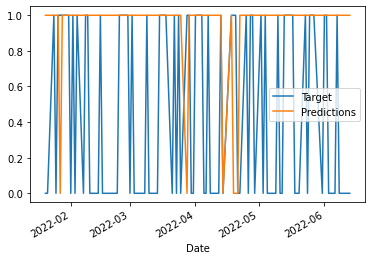

In [19]:
combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

In [20]:
#take first 1000 rows of data as our training set, take next 750 rows as test set, fit ml model to training set, make preds on test set
i = 1000
step = 750

train = data.iloc[0:i].copy()
test = data.iloc[i:(i+step)].copy()
model.fit(train[predictors], train["Target"])
preds = model.predict(test[predictors])

In [21]:
# using predict_proba method to get probabilities that the price will go up stead of just 0/1
# take second column of result to ensure that we only get the probability that the price goes up
# convert resut from np array to pd Series (easier to work with)
# if % chance that the price will go up is >60%, then say the price will go up
preds = model.predict_proba(test[predictors])[:,1]
preds = pd.Series(preds, index=test.index)
preds[preds > .6] = 1
preds[preds<=.6] = 0

In [22]:
preds.head()

Date
1990-02-27    1.0
1990-02-28    1.0
1990-03-01    1.0
1990-03-02    1.0
1990-03-05    1.0
dtype: float64

In [24]:
#put into loop
#generate preds on our train and test set
#combine preds with actual target
#add all preds into one list

predictions =[]
#loop over entire dataset in increments
for i in range(1000, data.shape[0], step):
    #split into train and test sets
    train = data.iloc[0:i].copy()
    test = data.iloc[i:(i+step)].copy()
    
    #fit random forest model
    model.fit(train[predictors], train["Target"])
    
    #make preds
    preds = model.predict_proba(test[predictors])[:,1]
    preds = pd.Series(preds, index=test.index)
    preds[ preds > .6] = 1
    preds[preds <= .6] = 0
    
    #combine predictions and test values
    combined = pd.concat({"Target": test["Target"], "Predictions": preds}, axis=1)
    
    predictions.append(combined)

In [25]:
predictions[0].head()

,Target,Predictions
Date,,
1990-02-27,0.0,1.0
1990-02-28,1.0,1.0
1990-03-01,1.0,1.0
1990-03-02,1.0,1.0
1990-03-05,1.0,1.0


In [26]:
# create backtesting function
#split training and test data
#train model
#make predictions on test data using predict_proba
#combine our predictions with the actual Target, so we can calculate error easily
#return all of the predictions
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Fit the random forest model
        model.fit(train[predictors], train["Target"])

        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds > .6] = 1
        preds[preds<=.6] = 0

        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

        predictions.append(combined)

    return pd.concat(predictions)

In [27]:
predictions = backtest(data, model, predictors)

In [28]:
predictions["Predictions"].value_counts()

0.0    7385
1.0     752
Name: Predictions, dtype: int64

In [29]:
predictions["Target"].value_counts()

1.0    4122
0.0    4015
Name: Target, dtype: int64

In [30]:
precision_score(predictions["Target"], predictions["Predictions"])

0.4946808510638298

In [31]:
weekly_mean = data.rolling(7).mean()["Close"]
quarterly_mean = data.rolling(90).mean()["Close"]
annual_mean = data.rolling(365).mean()["Close"]

In [32]:
#tell the algorithm how many days in the last week the price has gone up. use shift and rolling methods
#shift is used to not imcorporate info from current day into predictor
weekly_trend = data.shift(1).rolling(7).sum()["Target"]

In [33]:
#add ratios into our predictor df
data["weekly_mean"] = weekly_mean / data["Close"]
data["quarterly_mean"] = quarterly_mean / data["Close"]
data["annual_mean"] = annual_mean / data["Close"]

In [34]:
#add ratios between different rolling means, helps algorithm understand what the weekly trend is relative to annual trend
data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]

In [37]:
data.head(100)

,Actual_Close,Target,Close,Volume,Open,High,Low,weekly_mean,quarterly_mean,annual_mean,annual_weekly_mean,annual_quarterly_mean
Date,,,,,,,,,,,,
1986-03-14,0.063292,1.0,0.061109,1.031789e+09,0.055654,0.063838,0.055654,NaN,NaN,NaN,NaN,NaN
1986-03-17,0.064384,1.0,0.063292,3.081600e+08,0.061109,0.064384,0.061109,NaN,NaN,NaN,NaN,NaN
1986-03-18,0.062746,0.0,0.064384,1.331712e+08,0.063292,0.064929,0.063292,NaN,NaN,NaN,NaN,NaN
1986-03-19,0.061655,0.0,0.062746,6.776640e+07,0.064384,0.064929,0.062201,NaN,NaN,NaN,NaN,NaN
1986-03-20,0.060018,0.0,0.061655,4.789440e+07,0.062746,0.063292,0.061109,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1986-07-30,0.062746,0.0,0.064929,1.405440e+07,0.066566,0.067111,0.063838,1.022808,1.026747,NaN,NaN,NaN
1986-07-31,0.062201,0.0,0.062746,2.640960e+07,0.064929,0.064929,0.060564,1.053421,1.063241,NaN,NaN,NaN
1986-08-01,0.061655,0.0,0.062201,1.563840e+07,0.062746,0.063292,0.062201,1.051383,1.073542,NaN,NaN,NaN


In [39]:
#add weekly trend into predictor df
data["weekly_trend"] = weekly_trend

In [40]:
#adding ratios between intraday open low and high prices and close price
data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

In [42]:
#update predictors list with all the new preds we added
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", "open_close_ratio", "high_close_ratio", "low_close_ratio"]


In [43]:
predictions = backtest(data.iloc[365:], model, full_predictors)

In [44]:
precision_score(predictions["Target"], predictions["Predictions"])

0.6236162361623616

In [45]:
# Show how many trades we would make

predictions["Predictions"].value_counts()

0.0    7501
1.0     271
Name: Predictions, dtype: int64

<AxesSubplot:xlabel='Date'>

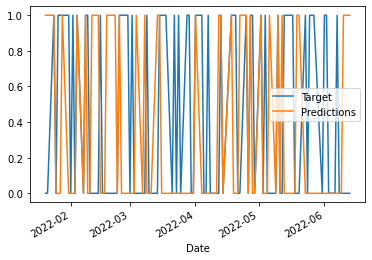

In [46]:
# Look at trades we would have made in the last 100 days

predictions.iloc[-100:].plot()